In [91]:


#import some necessary librairies

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)


from scipy import stats
from scipy.stats import norm, skew #for some statistics

In [92]:
from pathlib import Path

path = Path.cwd()
cleaned_data_path = path.parent / 'data' / 'cleaned'

countries = ['austria', 'belgium', 'germany', 'italy', 'netherlands']

df = {}
for country in countries :
    file_path = cleaned_data_path / (country+'.csv')
    df[country] = pd.read_csv(file_path)

We will have to start with finding the correlation of each of the features with incidence.

In [93]:
df_germany = df['germany']
# Find most important features relative to incidence
print("Find most important features relative to target")
corr = df['germany'].corr()
corr

Find most important features relative to target


,incidence,Acetaldehydsyndrom,Achsensymptom,Adeno-assoziierte_Viren,Adenovirusimpfstoff,Adipsie,Adynamie,Aggravation,Akantholyse,Akroosteolyse,...,Wehau-Krankheit,Winterbottom-Zeichen,Zahnschmerzen,Zervizitis,Zikavirus-Epidemie_2015/2016,Zohlen-Zeichen,Zwerchfellhochstand,Zyanose,Ödem,Übelkeit
incidence,1.000000,0.167898,-0.071102,0.171984,0.188441,0.206050,-0.064598,0.009689,0.048940,0.335227,...,-0.015310,0.101614,-0.190271,0.153048,0.232394,-0.043137,0.008650,0.037126,0.292596,0.311621
Acetaldehydsyndrom,0.167898,1.000000,0.179917,0.041927,0.556666,0.686579,0.161771,0.180830,0.054524,0.683043,...,0.379591,0.377792,-0.246062,0.371427,0.631098,0.003216,0.240057,0.230382,0.692590,0.692905
Achsensymptom,-0.071102,0.179917,1.000000,-0.099108,0.203146,0.047396,0.025251,0.013911,-0.077928,0.053742,...,0.192789,0.225826,-0.324153,-0.032207,0.068666,-0.157475,-0.131259,-0.066963,0.041089,0.046003
Adeno-assoziierte_Viren,0.171984,0.041927,-0.099108,1.000000,0.084552,0.367431,0.228979,0.188496,0.392999,0.151524,...,-0.174426,0.034894,0.156908,0.133463,0.091078,0.293058,0.362384,0.382144,0.147948,0.133214
Adenovirusimpfstoff,0.188441,0.556666,0.203146,0.084552,1.000000,0.557929,-0.246626,-0.008119,-0.170982,0.658736,...,0.048600,0.062584,-0.551020,0.312972,0.638172,-0.341176,-0.248635,-0.193737,0.656632,0.655823
Adipsie,0.206050,0.686579,0.047396,0.367431,0.557929,1.000000,-0.048894,0.027699,-0.012484,0.826887,...,-0.002814,0.140823,-0.387564,0.485737,0.763773,-0.172717,0.071132,0.094984,0.838922,0.828743
Adynamie,-0.064598,0.161771,0.025251,0.228979,-0.246626,-0.048894,1.000000,0.353684,0.694892,-0.204877,...,0.483591,0.499037,0.661961,-0.119993,-0.181986,0.826811,0.758355,0.857392,-0.206070,-0.205443
Aggravation,0.009689,0.180830,0.013911,0.188496,-0.008119,0.027699,0.353684,1.000000,0.314762,0.002146,...,0.231889,0.187583,0.257054,-0.021517,-0.005400,0.351434,0.276903,0.376994,0.004198,0.000474
Akantholyse,0.048940,0.054524,-0.077928,0.392999,-0.170982,-0.012484,0.694892,0.314762,1.000000,-0.152746,...,0.271003,0.358328,0.564385,-0.104370,-0.152625,0.736724,0.620064,0.705664,-0.166681,-0.159338
Akroosteolyse,0.335227,0.683043,0.053742,0.151524,0.658736,0.826887,-0.204877,0.002146,-0.152746,1.000000,...,-0.041889,0.102294,-0.500528,0.439169,0.906378,-0.285169,-0.158787,-0.017094,0.983425,0.981584


In [94]:
corr.sort_values(['incidence'], ascending = False, inplace = True)
corr['incidence']

incidence                                                 1.000000
Schüttelfrost                                             0.597271
Erkältung                                                 0.524202
Bradykardie                                               0.509491
FSME-Impfstoff                                            0.447844
Pertussisimpfstoff                                        0.397472
Totimpfstoff                                              0.396158
Lebendimpfstoff                                           0.393729
Lungenentzündung                                          0.391089
Intelligenzminderung                                      0.389284
Potato-Spindle-Tuber-Viroid                               0.374255
Akute_Mittelohrentzündung                                 0.372301
Gelbfieberimpfstoff                                       0.371007
Hepatitis-A-Impfstoff                                     0.366672
Unwohlsein_und_Ermüdung                                   0.36

In [95]:
count = 0
for column, correlation in corr['incidence'].items() :
    if count > 10:
        break
    if column == 'incidence' or column == 'week' or column == 'date':
        continue

    df['germany'][column+'-s2'] = df['germany'][column] ** 2
    df['germany'][column+'-s3'] = df['germany'][column] ** 3
    df['germany'][column+'-sq'] = np.sqrt(df['germany'][column])
    count += 1

df_germany = df['germany']

In [96]:
# Find most important features relative to incidence
print("Find most important features relative to target")
corr = df['germany'].corr()
corr.sort_values(['incidence'], ascending = False, inplace = True)
corr['incidence']

Find most important features relative to target


incidence                         1.000000
Schüttelfrost-s2                  0.689399
Erkältung-s3                      0.658495
Schüttelfrost-s3                  0.646824
Erkältung-s2                      0.637978
Schüttelfrost                     0.597271
Bradykardie-s2                    0.545914
Bradykardie-s3                    0.530987
Erkältung                         0.524202
Bradykardie                       0.509491
Intelligenzminderung-s3           0.478488
Schüttelfrost-sq                  0.465305
FSME-Impfstoff                    0.447844
Intelligenzminderung-s2           0.442595
Potato-Spindle-Tuber-Viroid-sq    0.438038
Lungenentzündung-s3               0.426897
Lungenentzündung-s2               0.426842
Erkältung-sq                      0.422323
Lebendimpfstoff-s2                0.416688
FSME-Impfstoff-sq                 0.416483
Lebendimpfstoff-s3                0.405869
Pertussisimpfstoff-s2             0.403686
Pertussisimpfstoff                0.397472
Totimpfstof

now we have to normalize and scale all the variables

In [97]:
numerical_features = df['germany'].select_dtypes(exclude = ["object"]).columns
numerical_features = numerical_features.drop('incidence')
numerical_features

Index(['Acetaldehydsyndrom', 'Achsensymptom', 'Adeno-assoziierte_Viren',
       'Adenovirusimpfstoff', 'Adipsie', 'Adynamie', 'Aggravation',
       'Akantholyse', 'Akroosteolyse', 'Akrozyanose',
       ...
       'Lungenentzündung-sq', 'Intelligenzminderung-s2',
       'Intelligenzminderung-s3', 'Intelligenzminderung-sq',
       'Potato-Spindle-Tuber-Viroid-s2', 'Potato-Spindle-Tuber-Viroid-s3',
       'Potato-Spindle-Tuber-Viroid-sq', 'Akute_Mittelohrentzündung-s2',
       'Akute_Mittelohrentzündung-s3', 'Akute_Mittelohrentzündung-sq'],
      dtype='object', length=332)

In [98]:
# As a general rule of thumb, a skewness with an absolute value > 0.5 is considered at least moderately skewed
skewness = df['germany'][numerical_features].apply(lambda x: skew(x))
skewness = skewness[abs(skewness) > 0.5]
print(str(skewness.shape[0]) + " skewed numerical features to log transform")

246 skewed numerical features to log transform


In [99]:
skewed_features = skewness.index
skewed_features

Index(['Achsensymptom', 'Adenovirusimpfstoff', 'Adipsie', 'Aggravation',
       'Akantholyse', 'Akroosteolyse', 'Akute_Bronchitis',
       'Akute_Mittelohrentzündung', 'Akute_eitrige_Thyreoiditis', 'Alkalose',
       ...
       'Lungenentzündung-s3', 'Lungenentzündung-sq', 'Intelligenzminderung-s2',
       'Intelligenzminderung-s3', 'Potato-Spindle-Tuber-Viroid-s2',
       'Potato-Spindle-Tuber-Viroid-s3', 'Potato-Spindle-Tuber-Viroid-sq',
       'Akute_Mittelohrentzündung-s2', 'Akute_Mittelohrentzündung-s3',
       'Akute_Mittelohrentzündung-sq'],
      dtype='object', length=246)

In [100]:
lmbda = {'germany': {}}
for feature in skewed_features:
    test = df['germany'][feature] + 1

    test, lmbda['germany'][feature] = stats.boxcox(test)
    test = pd.Series(test)

    df['germany'][feature] = test

lmbda['germany']

{'Achsensymptom': -1.4080150954810817,
 'Adenovirusimpfstoff': -1.0174861091749354,
 'Adipsie': 0.35262624289083017,
 'Aggravation': 0.48563102748982856,
 'Akantholyse': 0.7151600248512713,
 'Akroosteolyse': -0.6938072519104879,
 'Akute_Bronchitis': 0.5641419236278084,
 'Akute_Mittelohrentzündung': -0.262106872479792,
 'Akute_Mittelohrentzündung-s2': -0.13865115994284072,
 'Akute_Mittelohrentzündung-s3': -0.09304965071906153,
 'Akute_Mittelohrentzündung-sq': -0.4235591770162946,
 'Akute_eitrige_Thyreoiditis': 0.4995735119738846,
 'Alkalose': 0.7197830644428717,
 'Alkoholintoleranz': 0.5187635874062917,
 'Allgemeininfektion': 0.5852044505703591,
 'Anorexie': 0.7926194754371486,
 'Anthraximpfstoff': -0.5740457681813185,
 'Anti-NMDA-Rezeptor-Enzephalitis': 0.3170722048452852,
 'Anämie': -0.16582508129604803,
 'Arjenyattah-Epidemie': 0.4662181059304921,
 'Attische_Seuche': 0.415343796462567,
 'Azidose': 1.0863524883159648,
 'Bagatellisierung': 0.33257921929381906,
 'Bazex-Syndrom': -0.6558

In [101]:
for feature in numerical_features:
    test = df['germany'][feature]
    test -= test.mean()
    test /= test.std()
    df['germany'][feature] = test

In [102]:
df_germany = df['germany']
df['germany'].describe()

,incidence,Acetaldehydsyndrom,Achsensymptom,Adeno-assoziierte_Viren,Adenovirusimpfstoff,Adipsie,Adynamie,Aggravation,Akantholyse,Akroosteolyse,...,Lungenentzündung-sq,Intelligenzminderung-s2,Intelligenzminderung-s3,Intelligenzminderung-sq,Potato-Spindle-Tuber-Viroid-s2,Potato-Spindle-Tuber-Viroid-s3,Potato-Spindle-Tuber-Viroid-sq,Akute_Mittelohrentzündung-s2,Akute_Mittelohrentzündung-s3,Akute_Mittelohrentzündung-sq
count,312.000000,312.000000,312.000000,3.120000e+02,3.120000e+02,3.120000e+02,3.120000e+02,3.120000e+02,3.120000e+02,312.000000,...,3.120000e+02,3.120000e+02,3.120000e+02,3.120000e+02,312.000000,3.120000e+02,3.120000e+02,3.120000e+02,3.120000e+02,3.120000e+02
mean,3.665609,0.000000,0.000000,-6.832142e-17,-4.554761e-17,-5.465713e-16,-9.109522e-17,-3.074464e-16,9.109522e-17,0.000000,...,9.109522e-17,3.188333e-16,5.921189e-16,-1.366428e-16,0.000000,-1.821904e-16,-9.109522e-17,1.821904e-16,-9.109522e-17,1.366428e-16
std,7.651979,1.000000,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,0.000000,-1.376301,-0.745399,-2.802898e+00,-6.981225e-01,-2.819861e+00,-2.027455e+00,-3.848483e+00,-3.020090e+00,-0.684428,...,-1.101598e+00,-2.779326e+00,-2.779298e+00,-3.190156e+00,-1.941074,-1.938327e+00,-1.969363e+00,-9.240388e-01,-9.158308e-01,-9.985752e-01
25%,0.040000,-0.908529,-0.745399,-5.278540e-01,-6.981225e-01,-6.417739e-01,-5.687133e-01,-2.664615e-01,-5.122272e-01,-0.684428,...,-1.101598e+00,-6.835497e-01,-6.835479e-01,-6.428236e-01,-0.254780,-2.556822e-01,-1.987793e-01,-9.240388e-01,-9.158308e-01,-9.985752e-01
50%,0.475000,0.039656,-0.745399,-9.559561e-02,-6.981225e-01,-1.994884e-01,-1.436197e-01,1.079496e-01,-1.250925e-01,-0.684428,...,5.768671e-02,-4.842395e-02,-4.842385e-02,-1.432065e-02,0.019078,1.972640e-02,1.037559e-02,-1.747231e-01,-1.883776e-01,4.968868e-02
75%,3.467500,0.583283,1.245687,4.561026e-01,1.375547e+00,8.106180e-01,5.589034e-01,3.698471e-01,4.957376e-01,1.363982,...,8.894872e-01,4.972699e-01,4.972691e-01,5.085031e-01,0.273414,2.745937e-01,2.188625e-01,1.086220e+00,1.091023e+00,9.801423e-01
max,57.310000,2.871571,1.715966,3.771979e+00,1.620336e+00,2.266015e+00,2.769390e+00,1.015817e+01,3.804556e+00,1.653636,...,1.497640e+00,2.091058e+00,2.091057e+00,1.969796e+00,2.516750,2.514884e+00,2.714263e+00,1.552433e+00,1.553000e+00,1.520383e+00


Also transforming the incidence(trying different types)

/home/tejsukhatme/anaconda3/envs/forShogun/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval



 mu = 3.67 and sigma = 7.64

skewness is:	3.7579859389207195


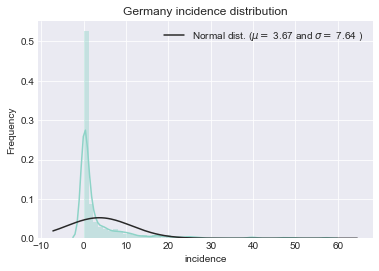

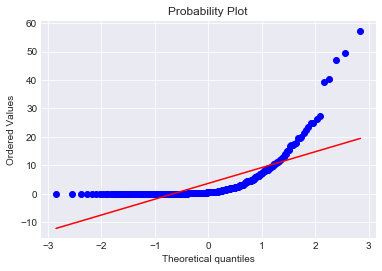

In [103]:
test = df['germany']['incidence']
sns.distplot(test , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(test)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Germany incidence distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(test, plot=plt)
plt.show()

print('skewness is:\t' + str(test.skew()))


 mu = 0.87 and sigma = 1.01

skewness after log1p is:	1.1210284366316425


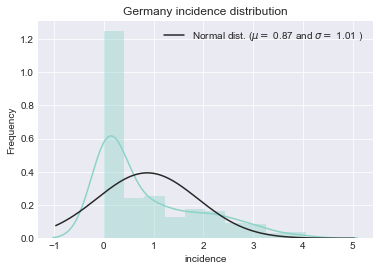

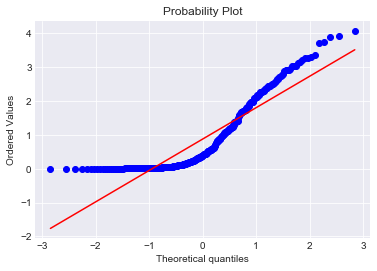

In [104]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
test = np.log1p(test)

#Check the new distribution
sns.distplot(test , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(test)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Germany incidence distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(test, plot=plt)
plt.show()

print('skewness after log1p is:\t' + str(test.skew()))


 mu = 0.47 and sigma = 0.44

skewness after yeojohnson is:	0.41976583970488685
lambda after yeojohnson is:	-0.7479037568078828


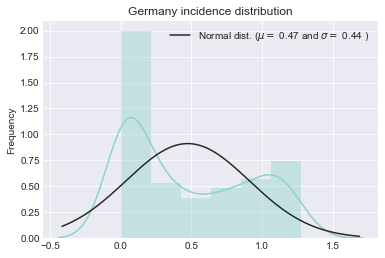

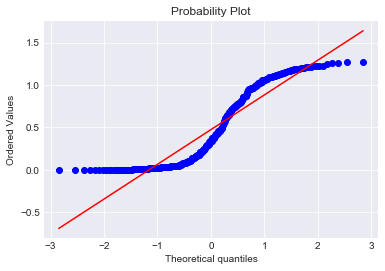

In [105]:
test = df['germany']['incidence'] + 1
test, lmbda_incidence = stats.boxcox(test)
test = pd.Series(test)

#Check the new distribution
sns.distplot(test , fit=norm)

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(test)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Germany incidence distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(test, plot=plt)
plt.show()

print('skewness after yeojohnson is:\t' + str(test.skew()))
print('lambda after yeojohnson is:\t' + str(lmbda_incidence))

We got the least skewness using yeojohnson.

In [106]:
df['germany']['incidence'] = test
lmbda['germany']['incidence'] = lmbda_incidence

df_germany = df['germany']

Now we have to deal with the week. This is a categorical variable whic we will one-encode.

In [107]:
week_number = []
for index, row in df['germany'].iterrows():
    week_number.append(row['week'][-2:])
week_number

df['germany']['week_number'] = week_number
df_germany = df['germany']

one hot encoding week numbers

In [108]:
one_hot_encoded_weeks = pd.get_dummies(df['germany']['week_number'], prefix='week')

In [109]:
df['germany'] = pd.concat([df['germany'], one_hot_encoded_weeks], axis=1)

df['germany'].drop(columns=['week_number'])

df_germany = df['germany']

we are done with features engineering for germany.
